In [1]:
# import the necessary packages

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns


# DBSCAN algorithm
We perform the density-based clustering using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm.
It has only two parameters...

- eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
- min_samples: the minimum number of points needed to create a cluster.
... and one output:
- cluster labels for each point in the dataset. Noisy samples are given the label -1.

## Pre-processing
We will use the normalized dataset with Min-Max approach to perform DBSCAN.

<Axes: >

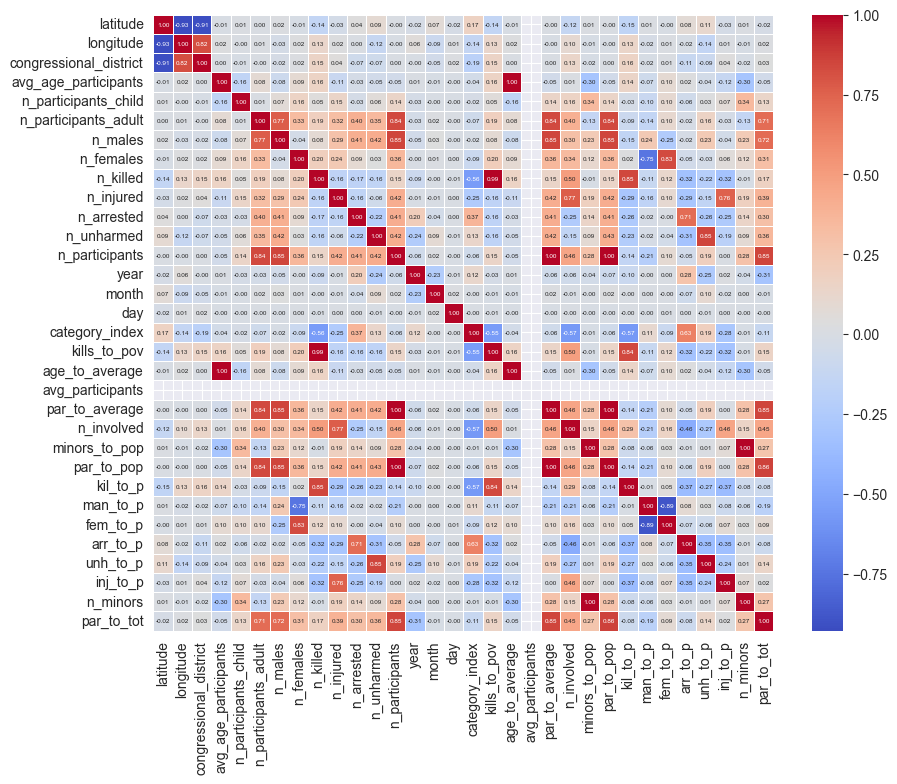

In [2]:
df = pd.read_csv('../data/extracted_features.csv')

standard = StandardScaler()
minmax = MinMaxScaler()

#pick the California data
df = df[df['state'] == 'California']

# plot correlation matrix to see if there is any feature to drop
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 4.6})

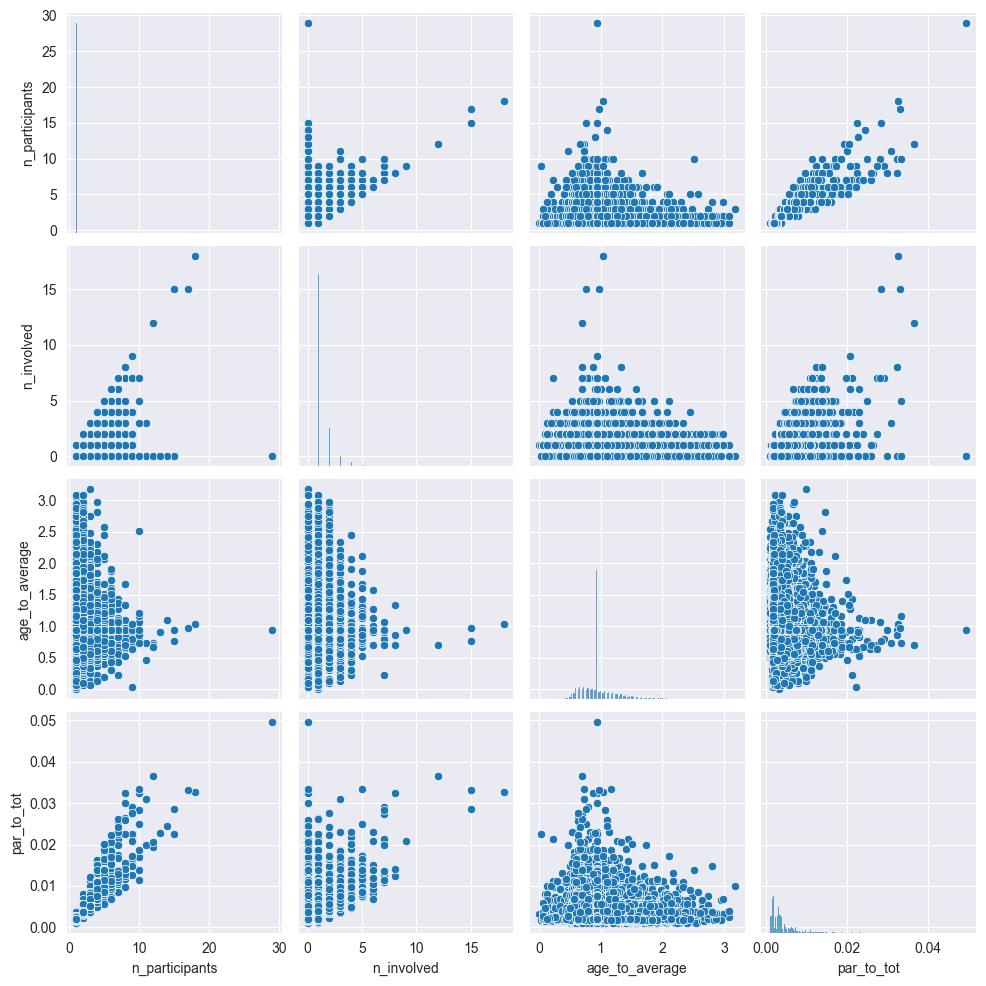

In [3]:
# select only the features that we want to use
new_df = df[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot']].dropna()
sns.pairplot(new_df)

In [4]:
# remove the outlier in californiaìs participants
new_df = new_df[new_df['n_participants'] < 20]

# scale the data
ss_scaled = standard.fit_transform(new_df)
mm_scaled = minmax.fit_transform(new_df)

In [5]:
from scipy.spatial.distance import pdist, squareform
import tqdm

def calc_k_nn_dist_graph(X, ub=0., lb=0.):
    k_list = [3, 5, 9]

    dist = pdist(X, 'euclidean')
    dist = squareform(dist)

    for k in k_list:
        kth_distances = []
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        plt.figure(figsize=(8, 6))
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.grid()
        plt.axhline(ub)
        plt.axhline(lb)
        plt.title('Graph of distance from %sth nearest neighbor' % k)
        plt.show()


In [6]:
# values of min_samples to try
min_samples = range(2, 15, 2)

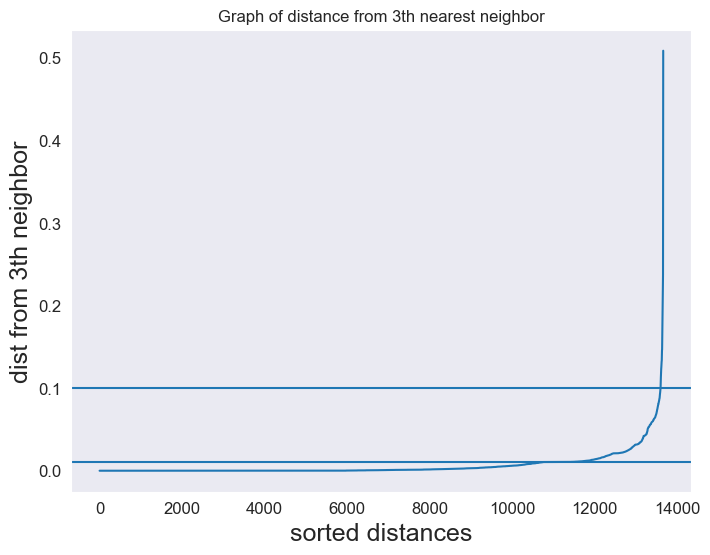

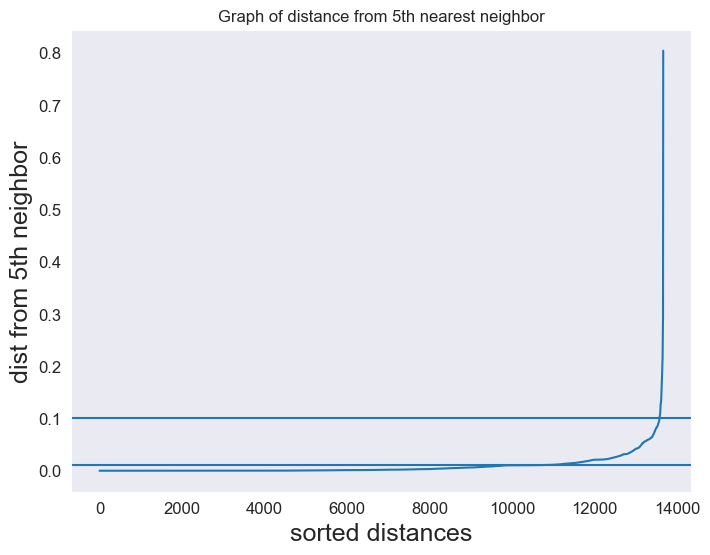

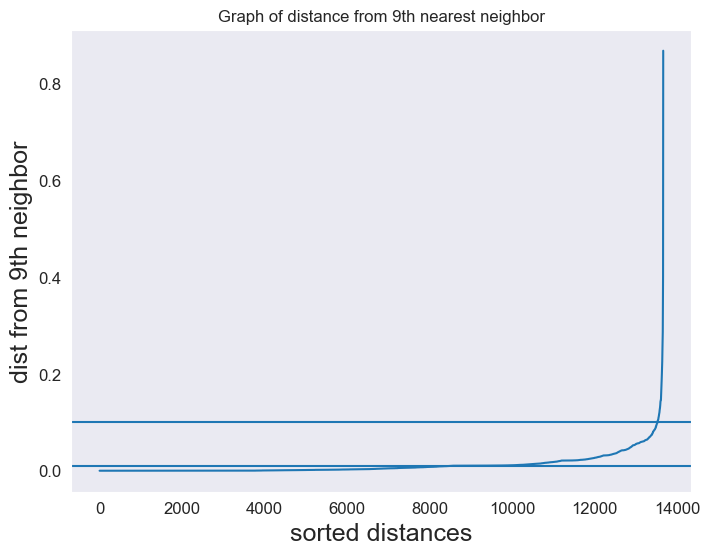

In [7]:
calc_k_nn_dist_graph(mm_scaled, 0.01, 0.1)

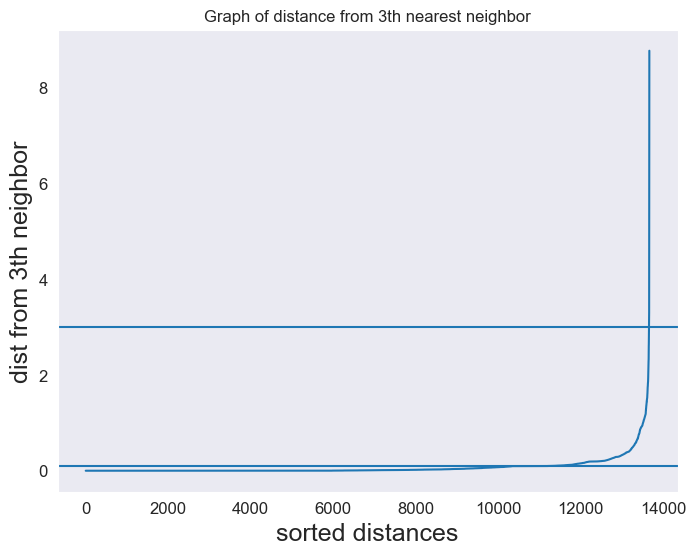

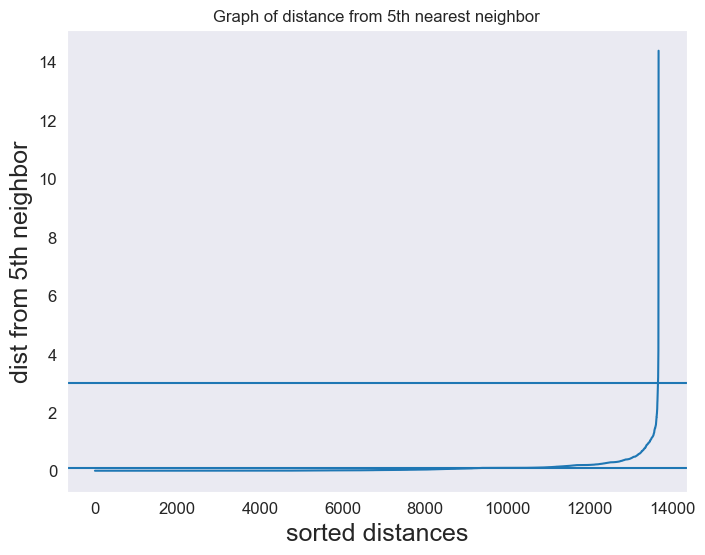

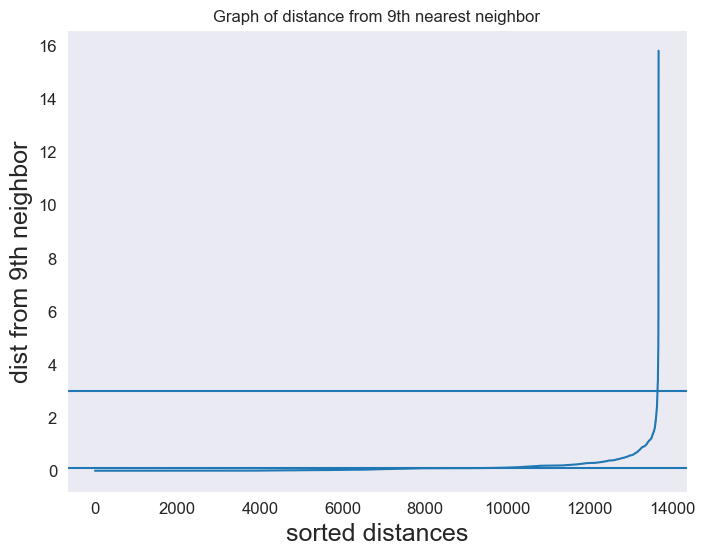

In [8]:

#repeat the same for standard scaled data
calc_k_nn_dist_graph(ss_scaled, 0.1, 3)

In [9]:
def print_best_params(silhouette_scores, parameter_combinations):
    best_score_index = np.argmax(silhouette_scores)  # Get the index of the maximum silhouette score
    best_params = parameter_combinations[best_score_index]  # Retrieve parameters corresponding to the best score

    best_eps, best_min_samples, n_clusters = best_params  # Unpack the best parameters

    best_score = silhouette_scores[best_score_index]  # Get the best silhouette score

    # Print the best silhouette score and corresponding parameters
    print(f"Best Silhouette Score: {best_score}")
    print(f"Best Parameters - eps: {best_eps}, min_samples: {best_min_samples}", f"Number of clusters: {n_clusters}")
    return best_eps, best_min_samples

# MinMax Scaling Test

In [10]:
mm_eps_values = np.arange(0.05, 0.125, 0.005)

In [ ]:
# test the best parameters for the DBSCAN algorithm
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None, 'n_clusters': None}
for eps in mm_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(mm_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 3: continue
        silhouette = silhouette_score(mm_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)


Number of clusters: 80, eps: 0.05, min_samples: 2 , Silhouette score: 0.057397679962113694
Number of clusters: 38, eps: 0.05, min_samples: 4 , Silhouette score: 0.06042385951656156
Number of clusters: 27, eps: 0.05, min_samples: 6 , Silhouette score: 0.06594502656186478
Number of clusters: 21, eps: 0.05, min_samples: 8 , Silhouette score: 0.0975900697039144
Number of clusters: 21, eps: 0.05, min_samples: 10 , Silhouette score: 0.09828421970539968
Number of clusters: 22, eps: 0.05, min_samples: 12 , Silhouette score: 0.09762655330176268
Number of clusters: 21, eps: 0.05, min_samples: 14 , Silhouette score: 0.08760686842258444
Number of clusters: 74, eps: 0.055, min_samples: 2 , Silhouette score: 0.0635715466161848
Number of clusters: 35, eps: 0.055, min_samples: 4 , Silhouette score: 0.06801893180386476
Number of clusters: 27, eps: 0.055, min_samples: 6 , Silhouette score: 0.06968102577319336
Number of clusters: 20, eps: 0.055, min_samples: 8 , Silhouette score: 0.10044076579561631
Numb

In [ ]:
eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
n_clusters = parameter_combinations[:, 2]

plt.figure(figsize=(10, 6))
plt.scatter(eps_values, min_samples_values, c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=n_clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(mm_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()

In [ ]:
dbscan = DBSCAN(eps=0.073, min_samples=3)
cluster_labels = dbscan.fit_predict(mm_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()


In [ ]:
# print examples for each cluster
for i in selected_data['cluster_labels'].unique():
    print(f"Cluster {i}")
    print(selected_data[selected_data['cluster_labels'] == i].head())
    print("\n")
    
selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()

# Standard Scaling Test

In [ ]:
ss_eps_values = np.linspace(0.2, 2.0, 10)

In [ ]:
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None}

for eps in ss_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(ss_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 4 or len(unique_labels) > 50: continue
        silhouette = silhouette_score(ss_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(parameter_combinations[:, 0], parameter_combinations[:, 1], c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
clusters = parameter_combinations[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(ss_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis',markers=['o', 's', '^', 'D'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=3)
cluster_labels = dbscan.fit_predict(ss_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis', markers=['o', 's', '^', 'D'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

In [ ]:
import plotly.express as px

if False:
    fig = px.scatter_mapbox(
        pd.merge(selected_data, df, how="right"), lat='latitude', lon='longitude',
        color='cluster_labels', mapbox_style="carto-positron",
        zoom=3, width=1000, height=600
    )
    fig.show()